**Differential Drive robot using Extended kalman filter**

Lets consider a problem of robot localization.

Assuming that our robot is wheeled, which means that it moves by turning it's wheels. When it does so, the robot turn around the rear axle while moving forward. This is non-linear behaviour.


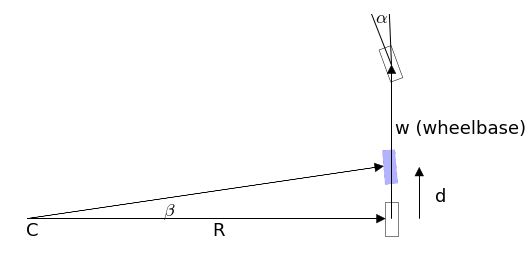

In [1]:
from IPython.display import Image
Image("C:/Users/suhas/Pictures/Robot_localization.png")

1) At a first approximation an automobile steers by turning the front tires while moving forward.

2) The front of the car moves in the direction that the wheels are pointing while turning around the rear tires.

3) This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. 

4) To Accurately model steering we need a set of differential equations.


**Refering to the above diagram:**

1) The front tire is pointing in direction $\alpha$

2) Over a short time period the car moves forward and the rear wheel ends up further ahead and slightly turned inward, as depicted with the blue shaded tire. 

3) Over such a short time frame we can approximate this as a turn around a radius R.


Formula to compute the turn angle $\beta$ is : $$\beta = \frac{d}{w} \tan{\alpha}$$

Formula to compute the turning radius is: $$R = \frac{d}{\beta}$$

The distance d is given by $$d = v \Delta t$$ where, v is the forward velocity.

If $\theta$ is our current orientation then we can compute the position C as 

$$C_x = x - R \sin(\theta)$$
$$C_y = y + R \cos(\theta)$$

After the move forward for time $\Delta t$ the new position and orientation of the robot is

$$x = C_x + R \sin(\theta + \beta) $$

$$y = C_y - R \cos(\theta + \beta) $$

$$\theta = \theta + \beta$$

Once we substitute in for CC we get

$$x = x - R \sin(\theta) + R \sin(\theta + \beta) $$

$$y = y + R \cos(\theta) - R \cos(\theta + \beta) $$

$$\theta = \theta + \beta$$

**These equations represent the motion of the robot and its is evident that the system is non-linear by seeing the equations.**

**Design our state variables**

In this example, we need to find position and orientation of the robot.

$$X =\begin{bmatrix}x \\ y \\ \theta
\end{bmatrix}$$

We can include velocity also to our state but that makes the problem more complicated. Therefore we will take velocity and steering angle as our control input u.

$$u =\begin{bmatrix}v \\ \alpha
\end{bmatrix}$$

**Design the system model**

Equation for the system with nonlinear motion model plus noise.

$$\hat{x} = x + f(x,u)$$

We can expand the above given motion equations as 

$$\begin{bmatrix}\hat x \\ \hat y \\ \hat\theta
\end{bmatrix} = \begin{bmatrix}x \\ y \\ \theta
\end{bmatrix} + \begin{bmatrix} - R \sin(\theta) + R \sin(\theta + \beta) \\ R \cos(\theta) - R \cos(\theta + \beta) \\ \beta \end{bmatrix}$$

We linearize this with a taylor expansion at x:

$$f(x,u) \approx x + \frac{\partial{f(x,u)}}{\partial{x}} $$

We replace f(x, u) with our state estimate X, and the derivative is the Jacobian of f.

$$F = \frac{\partial{f(x,u)}}{\partial{x}} = \begin{bmatrix} \frac{\partial{\dot{x}}}{\partial{x}} & \frac{\partial{\dot{x}}}{\partial{y}} & \frac{\partial{\dot{x}}}{\partial{\theta}} \\ 
\frac{\partial{\dot{x}}}{\partial{x}} & \frac{\partial{\dot{y}}}{\partial{y}} & \frac{\partial{\dot{y}}}{\partial{\theta}} \\
\frac{\partial{\dot{\theta}}}{\partial{x}} & \frac{\partial{\dot{\theta}}}{\partial{y}} & \frac{\partial{\dot{\theta}}}{\partial{\theta}}\end{bmatrix}$$

In [2]:
import sympy as sp

a, x, y, v, w, theta, time = sp.symbols('a, x, y, v, w, theta, t')

d = v*time
beta = (d/w)*sp.tan(a)
R = w/sp.tan(a)

X = sp.Matrix([x, y, theta])

f_x_u = sp.Matrix([[x-R*sp.sin(theta)+R*sp.sin(theta+beta)],
              [y+R*sp.cos(theta)-R*sp.cos(theta+beta)],
              [theta+beta]])

F = f_x_u.jacobian(X)

F


Matrix([
[1, 0, -w*cos(theta)/tan(a) + w*cos(t*v*tan(a)/w + theta)/tan(a)],
[0, 1, -w*sin(theta)/tan(a) + w*sin(t*v*tan(a)/w + theta)/tan(a)],
[0, 0,                                                         1]])

**Noise in the model**

The noise is in our control input, so it is in control space. 

When we command a specific velocity and steering angle, we need to convert that into errors in x, y, $\theta$.

In a real system this might vary depending on velocity, so it will need to be recomputed for every prediction. 

The noise model for this case is chosen as:
$$M = \begin{bmatrix} 0.01 v^2 & 0 \\ 0 & \sigma_{\alpha}^2\end{bmatrix}$$

$$V = \frac{\partial{f(x,u)}}{\partial{x}} = \begin{bmatrix} \frac{\partial{\dot{x}}}{\partial{v}} & \frac{\partial{\dot{x}}}{\partial{\alpha}} \\ 
\frac{\partial{\dot{x}}}{\partial{v}} & \frac{\partial{\dot{y}}}{\partial{\alpha}} \\
\frac{\partial{\dot{\theta}}}{\partial{v}} & \frac{\partial{\dot{\theta}}}{\partial{\alpha}}\end{bmatrix}$$

$$Q = VMV^T$$

In [3]:
u = sp.Matrix([v, a])
Q = f_x_u.jacobian(u)

Q

Matrix([
[t*cos(t*v*tan(a)/w + theta), t*v*(tan(a)**2 + 1)*cos(t*v*tan(a)/w + theta)/tan(a) - w*(-tan(a)**2 - 1)*sin(theta)/tan(a)**2 + w*(-tan(a)**2 - 1)*sin(t*v*tan(a)/w + theta)/tan(a)**2],
[t*sin(t*v*tan(a)/w + theta), t*v*(tan(a)**2 + 1)*sin(t*v*tan(a)/w + theta)/tan(a) + w*(-tan(a)**2 - 1)*cos(theta)/tan(a)**2 - w*(-tan(a)**2 - 1)*cos(t*v*tan(a)/w + theta)/tan(a)**2],
[                 t*tan(a)/w,                                                                                                                                   t*v*(tan(a)**2 + 1)/w]])

**The final form of our prediction equations are:**

<font color='blue'> $$x' = \begin{bmatrix}x \\ y \\ \theta
\end{bmatrix} + \begin{bmatrix} - R \sin(\theta) + R \sin(\theta + \beta) \\ R \cos(\theta) - R \cos(\theta + \beta) \\ \beta \end{bmatrix}$$

$$P' = FPF^T + Q $$</font>

**Design Measurement model**

For this problem we are assuming that we have a sensor that receives a noisy bearing and range to multiple known locations in the landscape. 

The measurement model must convert the state $$X =\begin{bmatrix}x \\ y \\ \theta
\end{bmatrix}$$
into a range and bearing to the landmark. 

$$range = r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

$$bearing = \phi = \arctan\frac{p_y - y}{p_x - x} - \theta$$

Thus, our function is

$$x = h(x,p) + Measurement Noise$$

$$x = \begin{bmatrix}\sqrt{(p_x - x)^2 + (p_y - y)^2} \\ \arctan\frac{p_y - y}{p_x - x} - \theta \end{bmatrix} + Measurement Noise$$

In [4]:
px, py = sp.symbols('px, py')
z = sp.Matrix([[sp.sqrt((px-x)**2 + (py-y)**2)],
            [sp.atan2(py-y, px-x) - theta]])

z.jacobian(X)

Matrix([
[(-px + x)/sqrt((px - x)**2 + (py - y)**2), (-py + y)/sqrt((px - x)**2 + (py - y)**2),  0],
[   -(-py + y)/((px - x)**2 + (py - y)**2),     -(px - x)/((px - x)**2 + (py - y)**2), -1]])

In [5]:
import math as math

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes the range and
    bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = math.sqrt(hyp)

    H = sp.Matrix(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

In [6]:
from math import atan2
def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement that would
    correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = math.sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = sp.Matrix([[dist],
                [math.atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

**Design Measurement Noise**

Measurement noise is defined in measurement space, hence it is linear. It is reasonable to assume that the range and bearing measurement noise is independent, hence

$$R = \begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

**The final form of our updation equations are:**

<font color='blue'> $$K = P' H^T (H P' H^T + R)^{-1}$$</font> 

<font color='blue'> $$x= x'+ K(z - h(x))$$</font> 

<font color='blue'> $$P = P'(I - KH)$$</font> 

<u>**SUMMARY**</u>

<u>**Equations:**</u>

**1) Prediction step:**

$$Linear:$$

<font color='red'> $$x' = Fx + Bu$$</font> 

<font color='blue'> $$P = FPF^T + Q$$</font> 

$$Non-linear:$$

<font color='red'> $$x' = x + f(x,u)$$</font> 

<font color='blue'> $$P' = FPF^T + Q$$</font> 


**2) Updation step:**

$$Linear:$$

<font color='blue'> $$K = P' H^T (H P' H^T + R)^{-1}$$</font> 

<font color='red'> $$x= x'+ K(z - H x')$$</font> 

<font color='blue'> $$P = P'(I - KH)$$</font> 

$$Non-Linear:$$

<font color='blue'> $$K = P' H^T (H P' H^T + R)^{-1}$$</font> 

<font color='red'> $$x= x'+ K(z - h(x))$$</font> 

<font color='blue'> $$P = P'(I - KH)$$</font> 

**Dimensions of the terms used in the equation**

| **Term** | **Name** | **Dimensions** |
| -------- | -------- | -------------- |
| x        | State Vector | $(n_x,1)$  |
| F        | State Transition Matrix | $(n_x,n_x)$  |
| B        | Control Matrix | $(n_x,n_u)$ |
| u        | Input Variable | $(n_u,1)$  |
| P        | Estimate Uncertainity | $(n_x,n_x)$  |
| Q        | Process Noise Uncertainity | $(n_x,n_x)$  |
| R        | Measurement Uncertainty | $(n_z,n_z)$  |
| K        | Kalman Gain | $(n_x,n_x)$  |
| H        | Observation Matrix | $(n_z,n_x)$  |
| z        | Measurement | $(n_z,1)$  |
| w        | Process noise Vector | $(n_x,1)$  |


**REFERENCE**

https://nbviewer.jupyter.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/tree/master/

In [12]:
var = sp.symbols('sigma^2_v')
dt, phi = sp.symbols('\Delta{t} \Phi_s')
v = sp.Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
# Q = Q / var
# sp.MatMul(Q, var)

In [13]:
print(var)

sigma^2_v
